<a href="https://colab.research.google.com/github/EA-park/AIFFEL_datathon/blob/pea/%5BDatathon%5D%EC%84%B8%EA%B3%84%ED%96%89%EB%B3%B5%EB%B3%B4%EA%B3%A0%EC%84%9C_%EC%84%B8%EA%B3%84%EC%A0%95%EB%B3%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#목차

1. 데이터 정리
 - 연도별 피처 이름(columns) 정리    
 - 연도별 국가 목록(row) 정리
2. 결측치 확인
 - None    
 - None 외 결측치 정리
3. 피처별 분포 확인
 - skewness    
 -이상치
4. 피처의 필요성 확인
 * 피처별 가중치 확인
    - GDP의 가중치가 가장 높다 -> 특정 국가의 행복지수에 GDP가 가장 큰 영향
 * 상관분석
    - 상위 국가에만 영향 주는 피처 존재 -> Freedom, Corruption, Generosity
    - Dystopia Residual은 Corruption, Generosity보다 값이 더 높은데, 2018-2019년에는 빠진 이유는 무엇인지?
     - Generosity는 가중치가 Corruption보다 높은데 비해, 상관분석에서의 관계성은 가장 낮다
5. 대륙별 행복지수




#설정

라이브러리 설정

In [1]:
import sys

import pandas as pd
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

경로 설정

In [2]:
from os.path import join
from google.colab import drive

In [3]:
ROOT = '/content/gdrive'
drive.mount(ROOT)

Mounted at /content/gdrive


In [4]:
PROJ = 'MyDrive/AIFFEL/[Datathon] 세계행복보고서'
WORKING_DIR = join(ROOT, PROJ)

#데이터 정리

In [5]:
happiness2015 = pd.read_csv(join(WORKING_DIR, '2015.csv'))
happiness2016 = pd.read_csv(join(WORKING_DIR, '2016.csv'))
happiness2017 = pd.read_csv(join(WORKING_DIR, '2017.csv'))
happiness2018 = pd.read_csv(join(WORKING_DIR, '2018.csv'))
happiness2019 = pd.read_csv(join(WORKING_DIR, '2019.csv'))

연도별 피처 이름(columns) 정리

In [6]:
keys2015 = happiness2015.keys().tolist()
keys2015[5:5]=['-', '-']

keys2016 = happiness2016.keys().tolist()
keys2016.insert(4,'-')

keys2017 = happiness2017.keys().tolist()
keys2017.insert(1, '-')
keys2017.insert(4, '-')
keys2017[5], keys2017[6] = keys2017[6], keys2017[5]
keys2017[-3], keys2017[-2] = keys2017[-2], keys2017[-3]
#map(keys2017.insert, [1, 4], ['-', '-'])

keys2018 = happiness2018.keys().tolist()
keys2018.insert(1, '-')
keys2018[0], keys2018[2] = keys2018[2], keys2018[0]
keys2018[4:4]=['-', '-', '-']
keys2018[-2], keys2018[-1] = keys2018[-1], keys2018[-2]
keys2018.append('-')

keys2019 = happiness2019.keys().tolist()
keys2019.insert(1, '-')
keys2019[0], keys2019[2] = keys2019[2], keys2019[0]
keys2019[4:4]=['-', '-', '-']
keys2019[-2], keys2019[-1] = keys2019[-1], keys2019[-2]
keys2019.append('-')

features = ['Country', 'Region', 'Rank', 'Score', 'Standard Error', 'LCI', 'UCI', 'GDP', 'Social Support', 'Healthy Life Expectancy', 'Freedom', 'Corruption', 'Generosity', 'Dystopia Residual']
df_keys = pd.DataFrame(index=np.linspace(2015,2019,5,dtype=int), data=[keys2015, keys2016, keys2017, keys2018, keys2019], columns=features)
display(df_keys)

,Country,Region,Rank,Score,Standard Error,LCI,UCI,GDP,Social Support,Healthy Life Expectancy,Freedom,Corruption,Generosity,Dystopia Residual
2015,Country,Region,Happiness Rank,Happiness Score,Standard Error,-,-,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
2016,Country,Region,Happiness Rank,Happiness Score,-,Lower Confidence Interval,Upper Confidence Interval,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
2017,Country,-,Happiness.Rank,Happiness.Score,-,Whisker.low,Whisker.high,Economy..GDP.per.Capita.,Family,Health..Life.Expectancy.,Freedom,Trust..Government.Corruption.,Generosity,Dystopia.Residual
2018,Country or region,-,Overall rank,Score,-,-,-,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Perceptions of corruption,Generosity,-
2019,Country or region,-,Overall rank,Score,-,-,-,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Perceptions of corruption,Generosity,-


In [7]:
happiness2015.rename(columns = {'Happiness Rank':'Rank','Happiness Score':'Score', 'Economy (GDP per Capita)':'GDP', 'Family':'Social Support', 'Health (Life Expectancy)':'Healthy Life Expectancy', 'Trust (Government Corruption)':'Corruption'},inplace=True)
happiness2016.rename(columns = {'Happiness Rank':'Rank','Happiness Score':'Score', 'Lower Confidence Interval':'LCI', 'Upper Confidence Interval':'UCI', 'Economy (GDP per Capita)':'GDP', 'Family':'Social Support', 'Health (Life Expectancy)':'Healthy Life Expectancy', 'Trust (Government Corruption)':'Corruption'},inplace=True)
happiness2017.rename(columns = {'Happiness.Rank':'Rank','Happiness.Score':'Score', 'Economy..GDP.per.Capita.':'GDP', 'Family':'Social Support', 'Health..Life.Expectancy.':'Healthy Life Expectancy', 'Trust..Government.Corruption.':'Corruption', 'Dystopia.Residual':'Dystopia Residual', 'Whisker.low':'LCI', 'Whisker.high':'UCI'},inplace=True)
happiness2018.rename(columns = {'Country or region':'Country','Overall rank':'Rank', 'GDP per capita':'GDP', 'Freedom to make life choices':'Freedom','Social support':'Social Support', 'Healthy life expectancy':'Healthy Life Expectancy', 'Perceptions of corruption':'Corruption'},inplace=True)
happiness2019.rename(columns = {'Country or region':'Country','Overall rank':'Rank', 'GDP per capita':'GDP', 'Freedom to make life choices':'Freedom','Social support':'Social Support', 'Healthy life expectancy':'Healthy Life Expectancy', 'Perceptions of corruption':'Corruption'},inplace=True)
# 바로 위의 셀을 재실행해서 이름 변경 확인

연도별 국가 목록(row) 정리

#결측치 확인

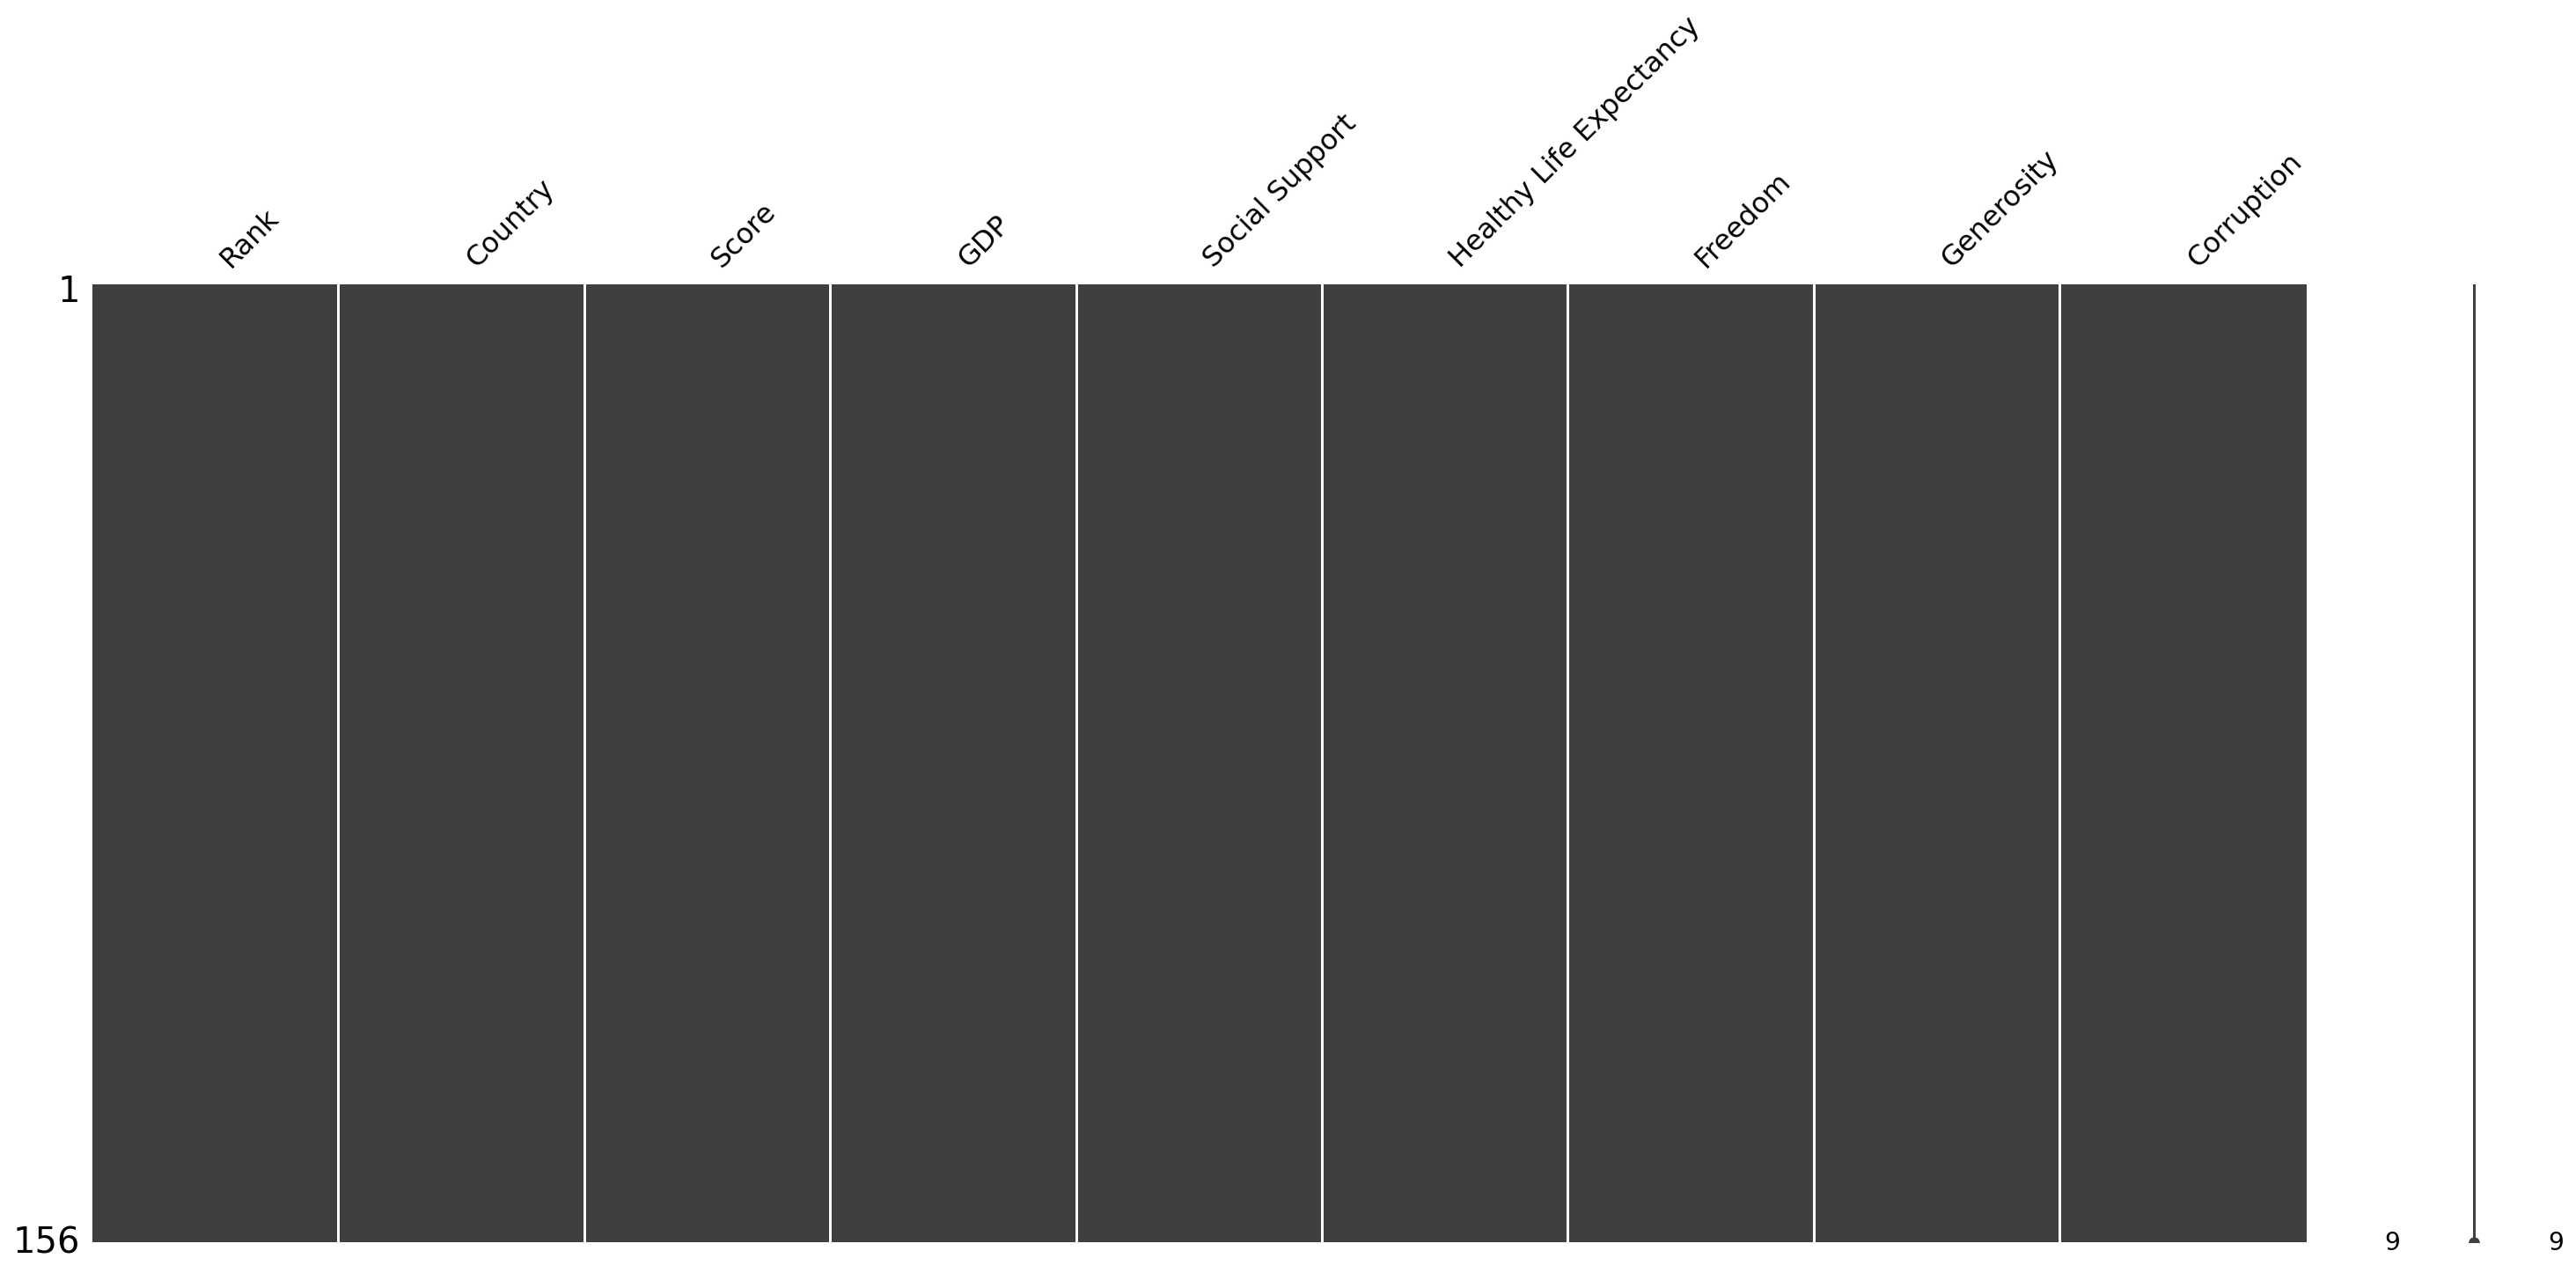

In [8]:
msno.matrix(happiness2019)
plt.show()

None 외 결측치 정리

In [33]:
# 값이 0인 행 개수 카운트
for c in happiness2019.columns:
    print(f'{c} : {len(happiness2019[happiness2019[c]==0])}')

Rank : 0
Country : 0
Score : 0
GDP : 1
Social Support : 1
Healthy Life Expectancy : 1
Freedom : 1
Generosity : 1
Corruption : 1


#피처별 분포 확인

###목적변수 skewness 확인

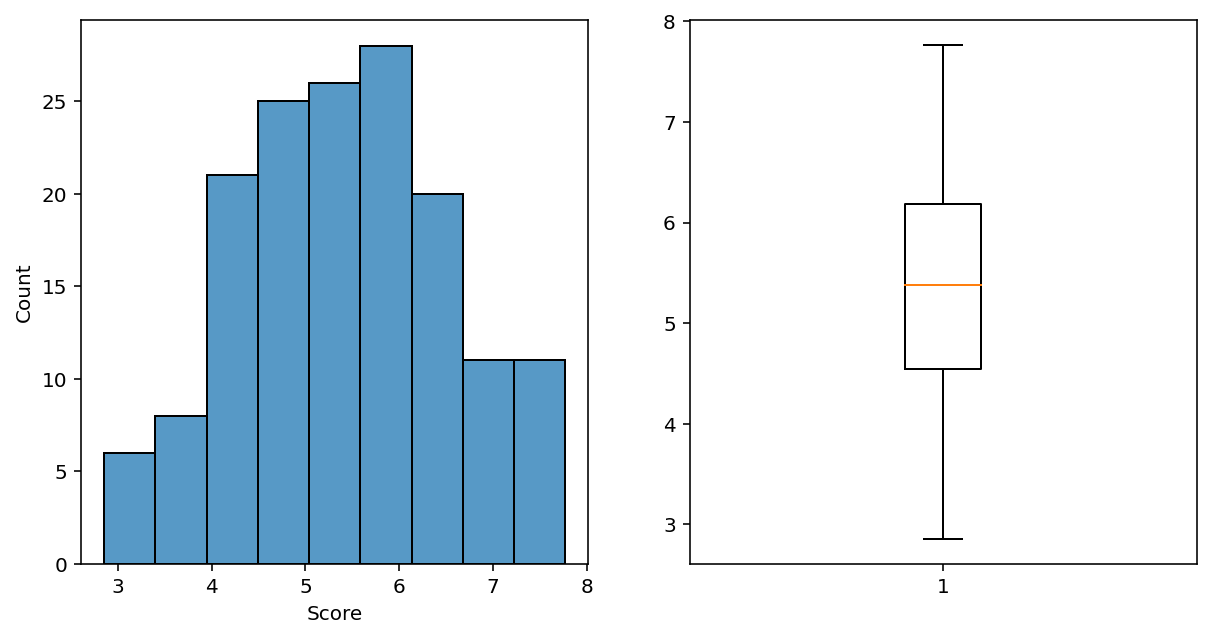

In [9]:
plt.figure(figsize=[10,5])
plt.subplot(1,2,1)
sns.histplot(happiness2019.Score)
plt.subplot(1,2,2)
plt.boxplot(happiness2019.Score)
plt.show()

피처 이상치 확인

In [10]:
keys = happiness2019.keys()
keys = keys[3:]

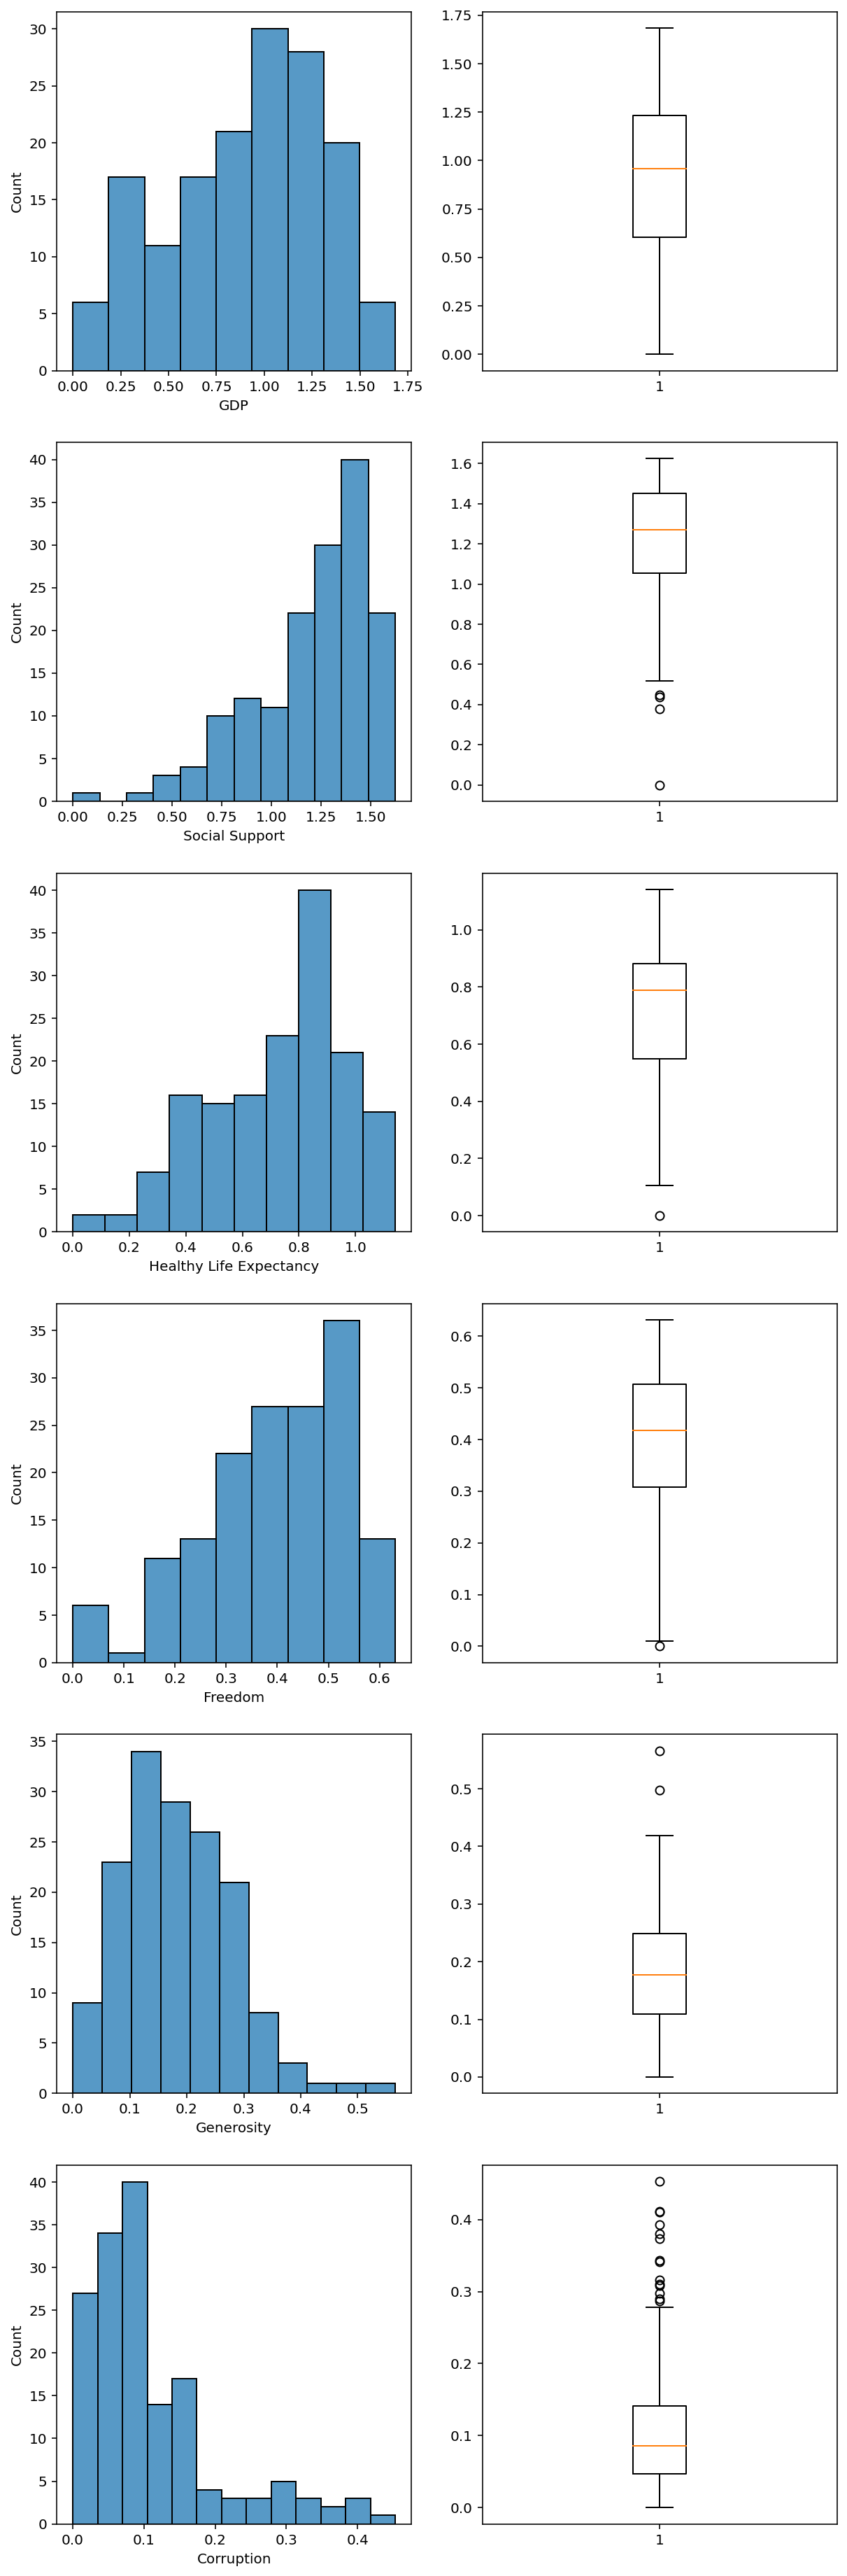

In [11]:
plt.figure(figsize=[10,50])
for iter, key in enumerate(keys):
    plt.subplot(9,2,2*iter+1)
    sns.histplot(happiness2019[key])
    plt.subplot(9,2,2*iter+2)
    plt.boxplot(happiness2019[key])
plt.show()



---



#피처의 필요성 확인

In [12]:
features_tmp = features[3:4] + features[7:]
happiness = [happiness2015, happiness2016, happiness2017, happiness2018, happiness2019]

각 피처별 가중치 확인
- score가 각 피처의 단순 합산인 것은, 피처의 값에 이미 가중치가 계산되었다고 판단
- 각 피처의 최대값(만점) 정보가 없어서, 전체 데이터에서 각 피처의 최대값을 확인함

In [13]:
statistics = {i:{'max':None, 'min':None} for i in features_tmp}
statistics

{'Score': {'max': None, 'min': None},
 'GDP': {'max': None, 'min': None},
 'Social Support': {'max': None, 'min': None},
 'Healthy Life Expectancy': {'max': None, 'min': None},
 'Freedom': {'max': None, 'min': None},
 'Corruption': {'max': None, 'min': None},
 'Generosity': {'max': None, 'min': None},
 'Dystopia Residual': {'max': None, 'min': None}}

In [14]:
for feature in features_tmp:
    print(feature)
    max_tmp = []
    min_tmp = []
    for index, year in enumerate(happiness):
        try:
            max_tmp.append(year[feature].max())
        except KeyError:
            pass
        else:
            min_tmp.append(year[feature].min())
    print(max_tmp)
    statistics[feature]['max'] = max(max_tmp)
    statistics[feature]['min'] = min(min_tmp)

Score
[7.587, 7.526, 7.53700017929077, 7.632, 7.769]
GDP
[1.69042, 1.82427, 1.87076568603516, 2.096, 1.684]
Social Support
[1.40223, 1.18326, 1.6105740070343, 1.644, 1.624]
Healthy Life Expectancy
[1.02525, 0.95277, 0.949492394924164, 1.03, 1.141]
Freedom
[0.66973, 0.60848, 0.658248662948608, 0.724, 0.631]
Corruption
[0.55191, 0.50521, 0.46430778503418, 0.457, 0.453]
Generosity
[0.79588, 0.81971, 0.838075160980225, 0.598, 0.566]
Dystopia Residual
[3.60214, 3.83772, 3.11748456954956]


In [23]:
statistics['Score']['max'] = 10.0
statistics['Score']['min'] = 0.0
statistics['Dystopia Residual']['max'] = 3.19   # 미조정 시 4.5 정도
statistics['Dystopia Residual']['min'] = 0.0
statistics

{'Score': {'max': 10.0, 'min': 0.0},
 'GDP': {'max': 2.096, 'min': 0.0},
 'Social Support': {'max': 1.644, 'min': 0.0},
 'Healthy Life Expectancy': {'max': 1.141, 'min': 0.0},
 'Freedom': {'max': 0.724, 'min': 0.0},
 'Corruption': {'max': 0.55191, 'min': 0.0},
 'Generosity': {'max': 0.838075160980225, 'min': 0.0},
 'Dystopia Residual': {'max': 3.19, 'min': 0.0}}

total value : 10.184985160980226


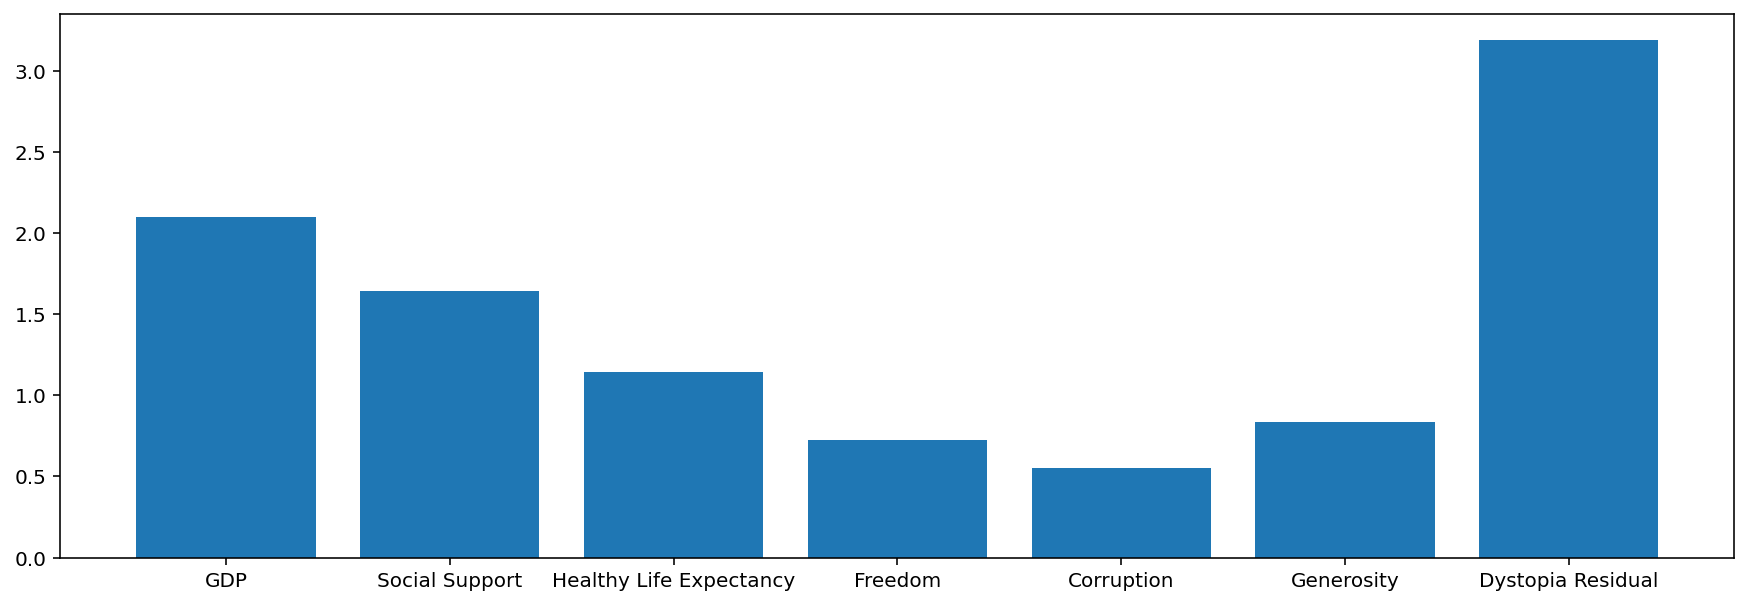

In [36]:
max = [statistics[i]['max'] for i in features_tmp[1:]]
print(f"total value : {sum(max)}")  #실제 max score = 10

plt.figure(figsize=(15,5))
plt.bar(features_tmp[1:], max)
plt.show()

###1. Dystopia Residual

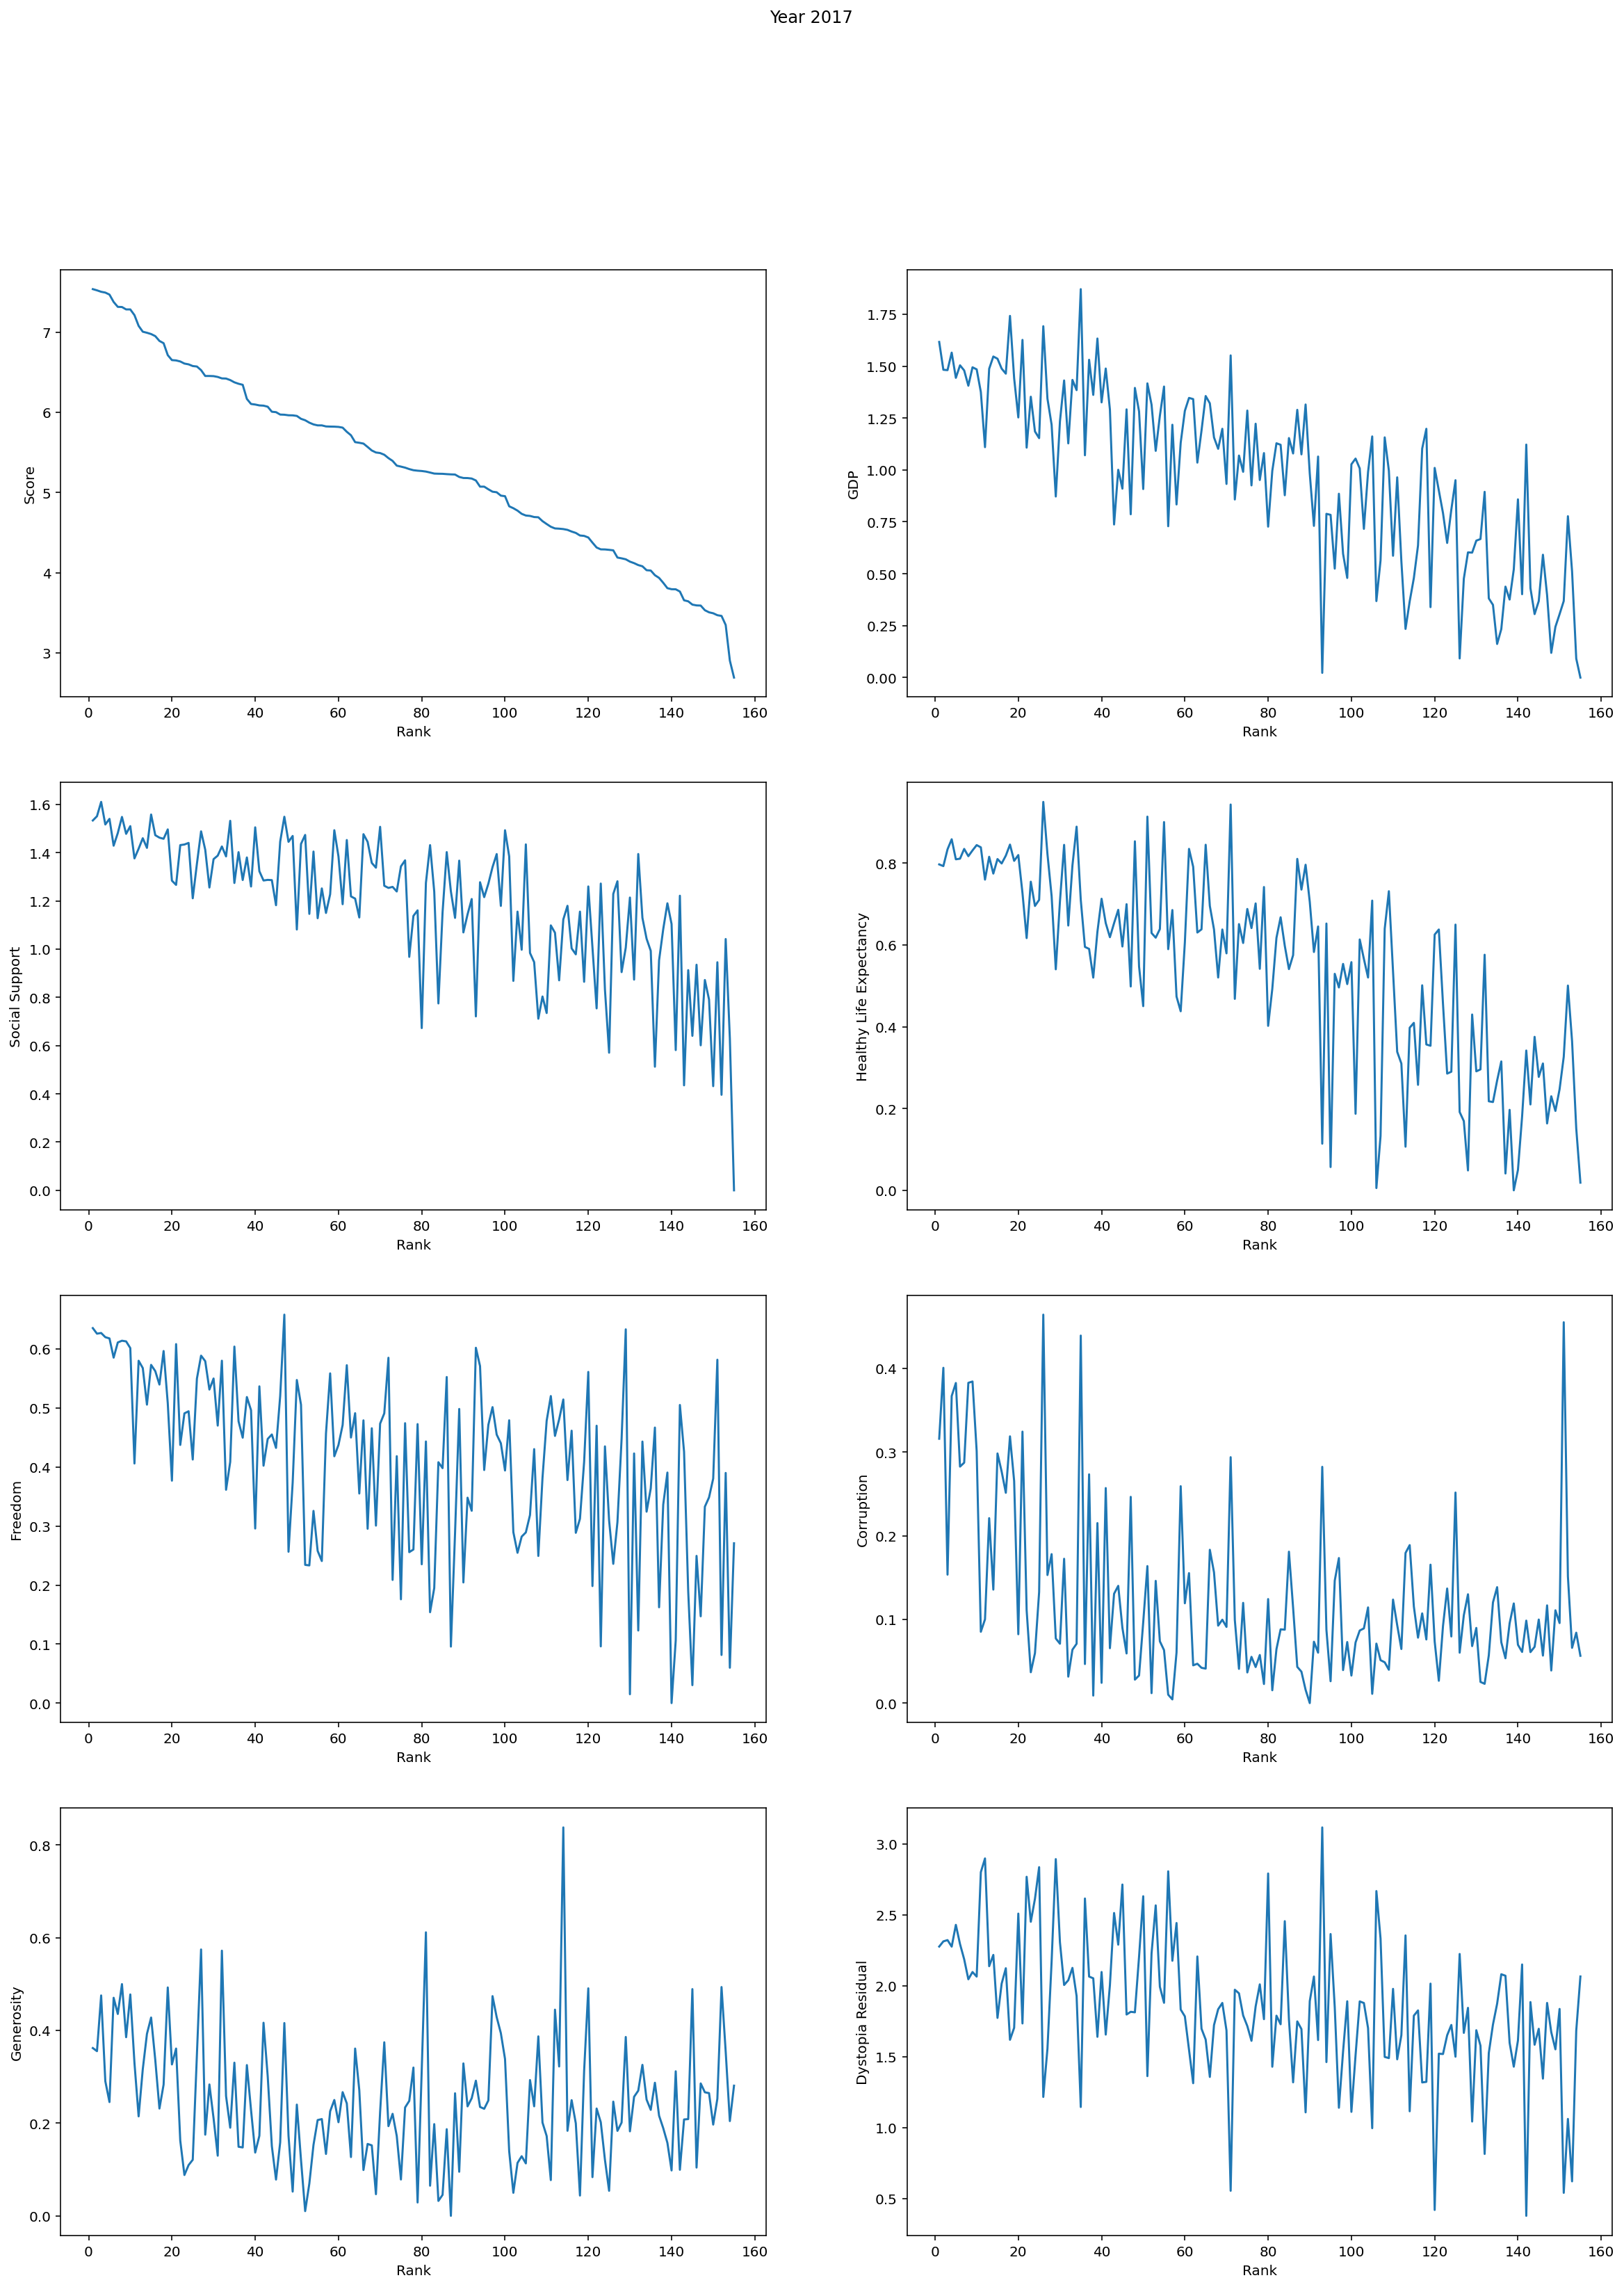

In [26]:
plt.figure(figsize=(20,26))
plt.suptitle('Year 2017')
for iter, feature in enumerate(features_tmp):
    plt.subplot(4,2,iter+1)
    plt.plot(happiness2017.Rank, happiness2017[feature])
    plt.ylabel(feature)
    plt.xlabel('Rank')
plt.show()

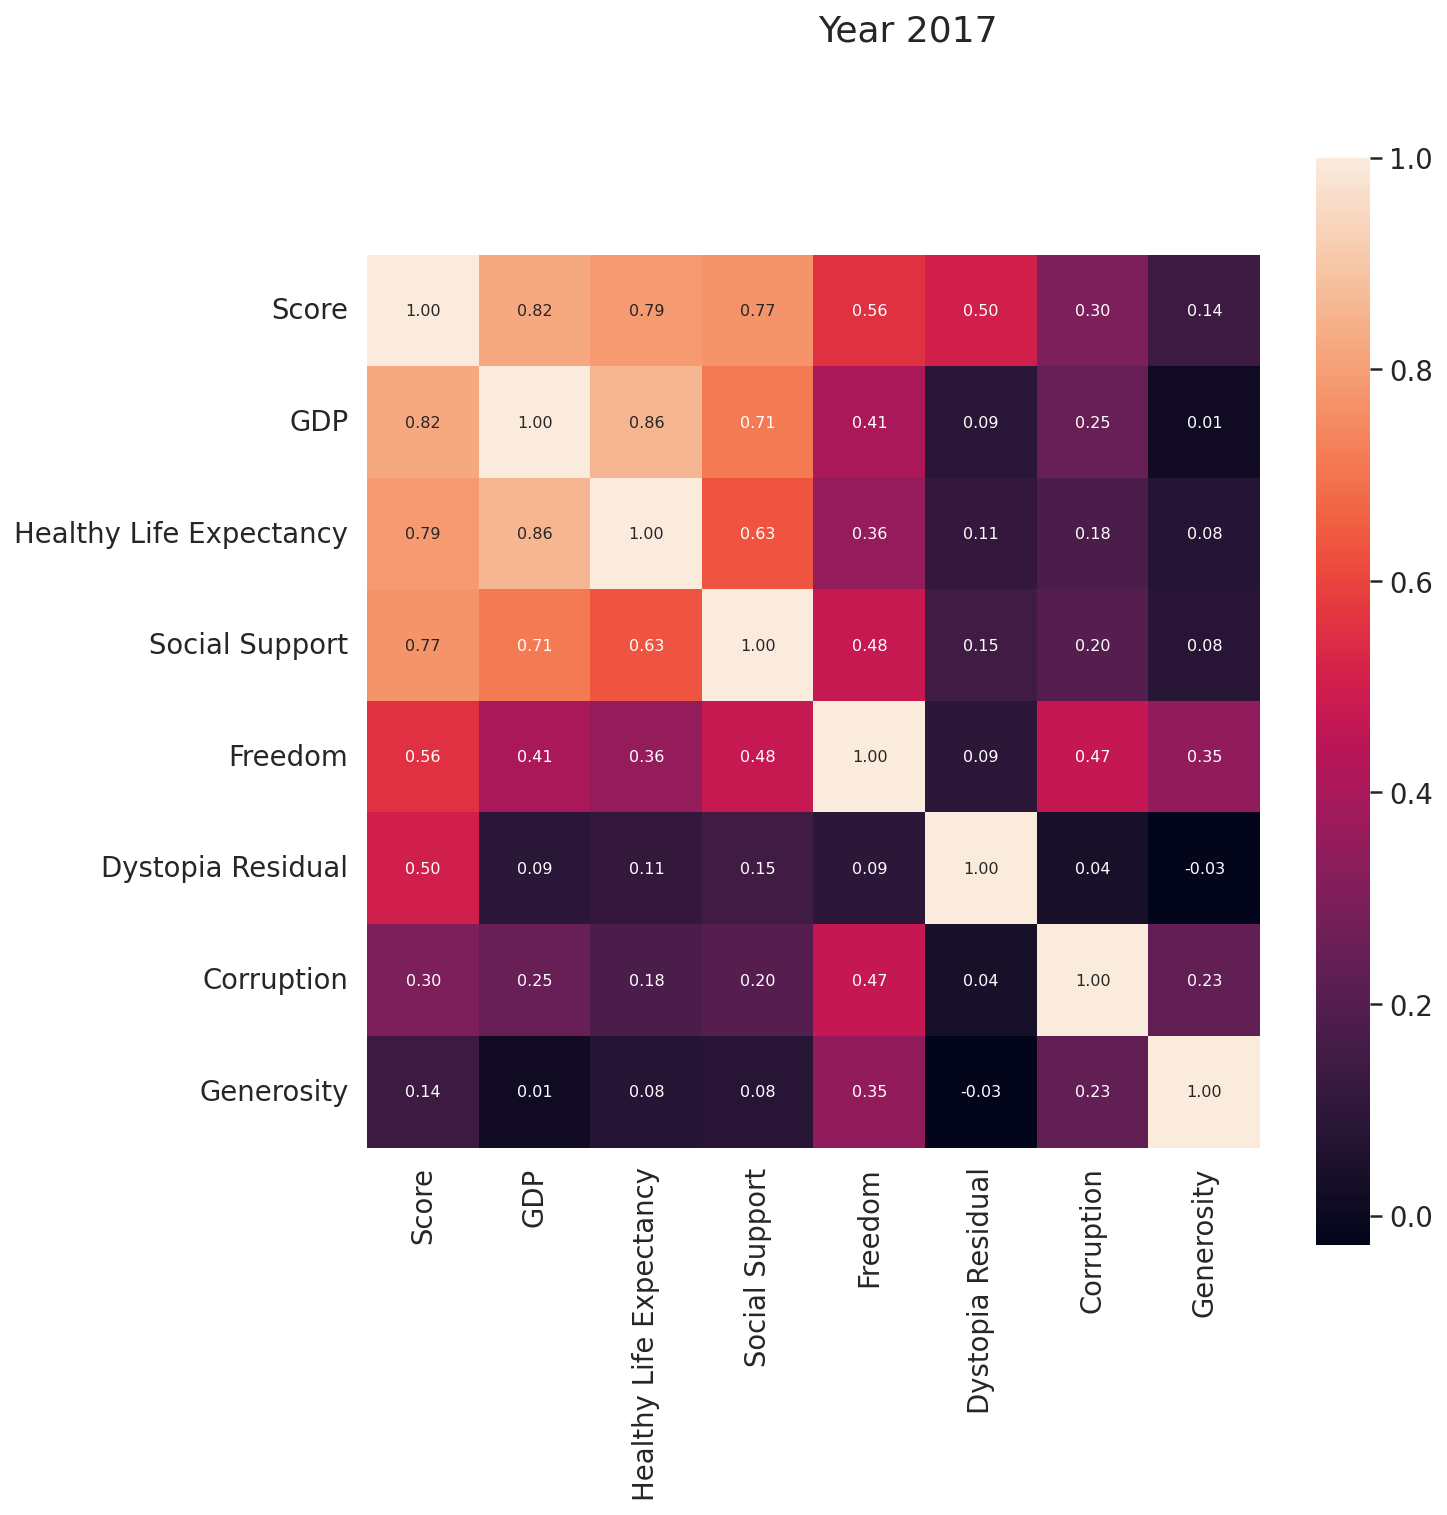

In [29]:
cor_abs = abs(happiness2017[features_tmp].corr(method='spearman'))
cor_cols = cor_abs.nlargest(n=8, columns='Score').index
cor = np.array(sp.stats.spearmanr(happiness2017[cor_cols].values))[0]
plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
sns.heatmap(cor, fmt='.2f', annot=True, square=True, annot_kws={'size' : 8}, xticklabels=cor_cols.values, yticklabels=cor_cols.values)
plt.suptitle('Year 2017')
plt.show()

- Dystopia Residual은 Corruption, Generosity보다 값이 더 높은데, 2018-2019년에는 빠진 이유는 무엇인지?

###2. Generosity

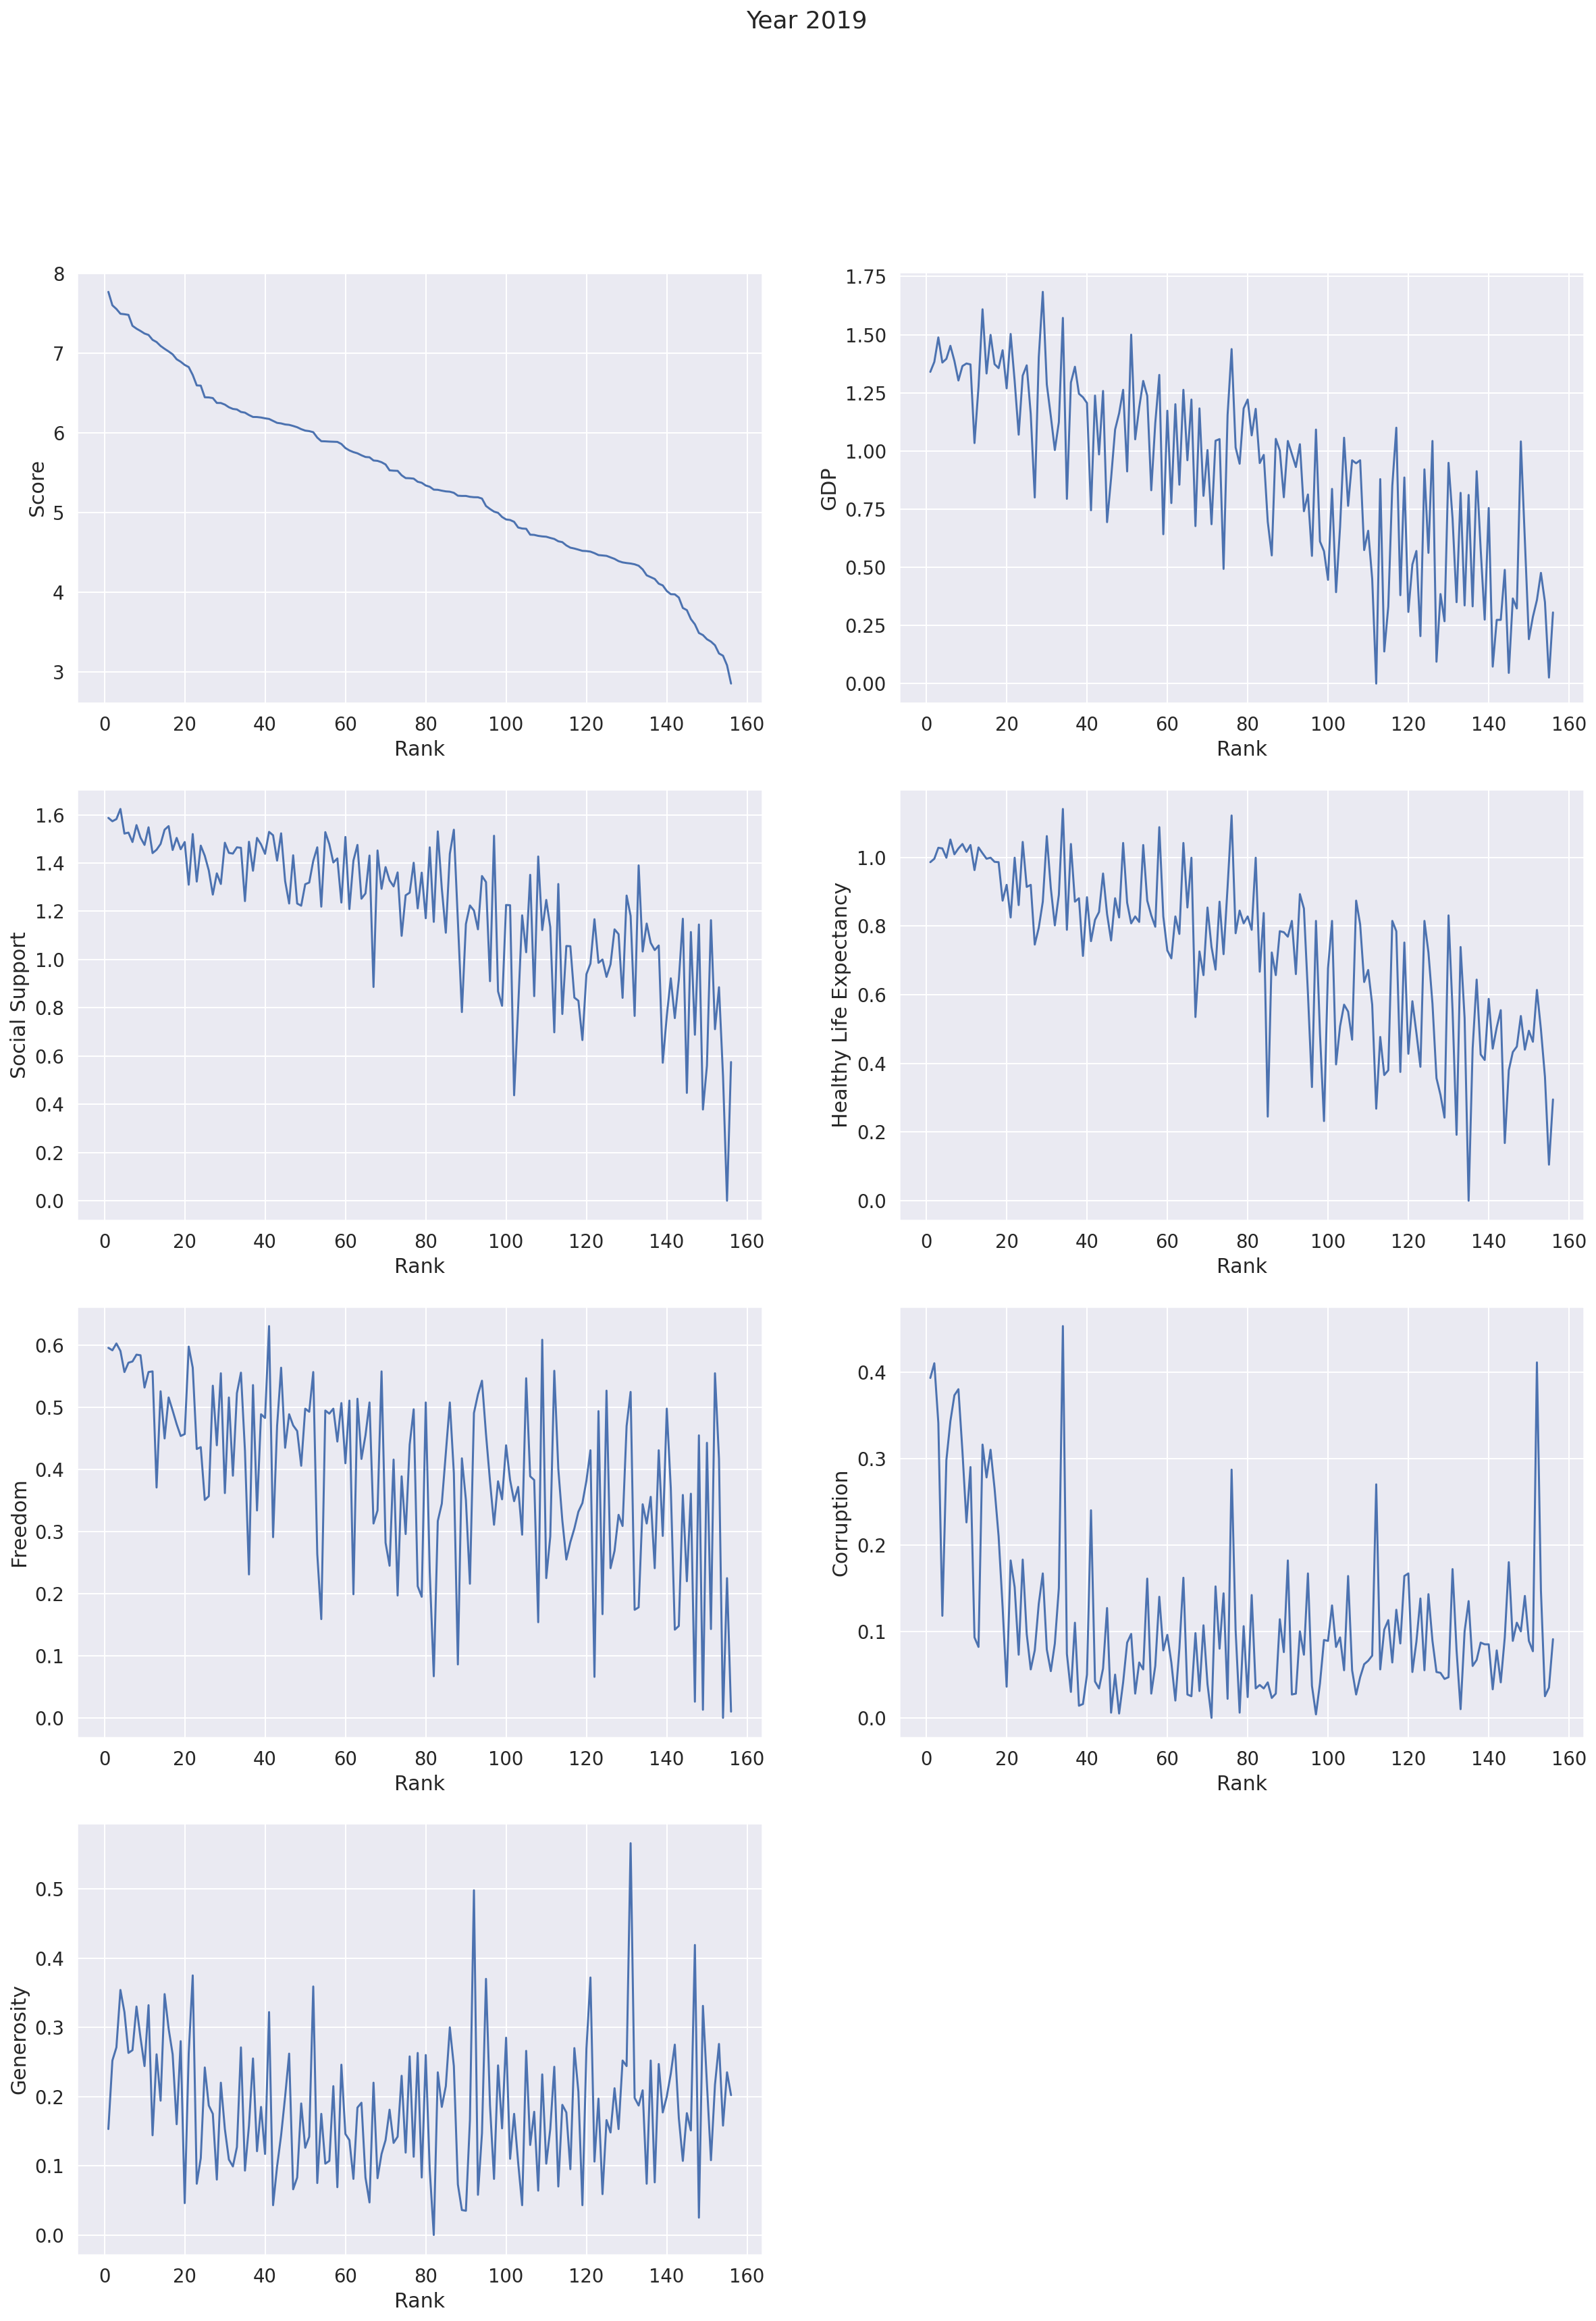

In [30]:
plt.figure(figsize=(20,27))
plt.suptitle('Year 2019')
for iter, feature in enumerate(features_tmp):
    if feature == 'Dystopia Residual':
        continue
    plt.subplot(4,2,iter+1)
    plt.plot(happiness2019.Rank, happiness2019[feature])
    plt.xlabel('Rank')
    plt.ylabel(feature)
plt.show()

- Corruption과 Generosity는 1-40위의 분별력을 위해 추가된 것으로 보임

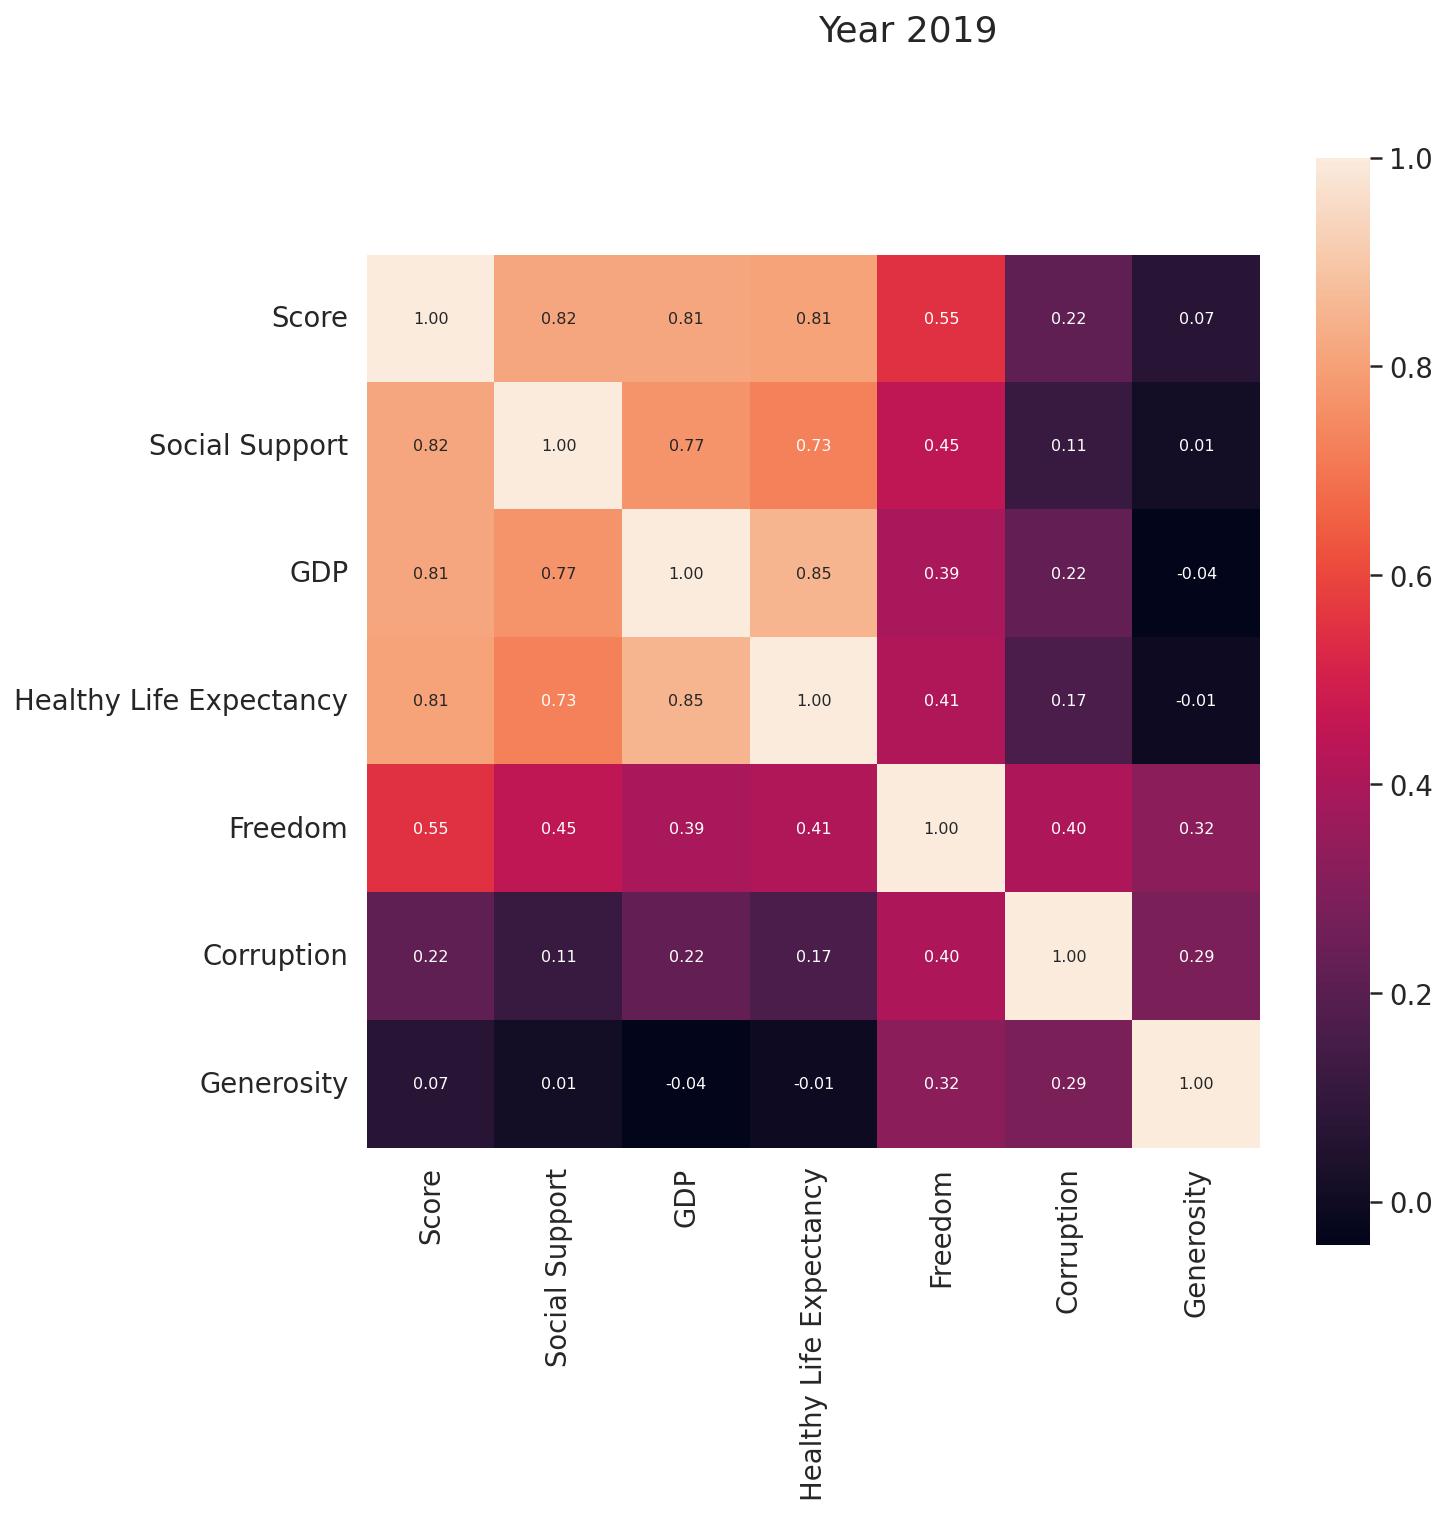

In [36]:
cor_abs = abs(happiness2019[features_tmp[:-1]].corr(method='spearman'))
cor_cols = cor_abs.nlargest(n=7, columns='Score').index
cor = np.array(sp.stats.spearmanr(happiness2019[cor_cols].values))[0]
plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
sns.heatmap(cor, fmt='.2f', annot=True, square=True, annot_kws={'size' : 8}, xticklabels=cor_cols.values, yticklabels=cor_cols.values)
plt.suptitle('Year 2019')
plt.show()

- 2017년 데이터와 비교했을 때, Social Support 비중이 높아짐
- Generosity는 가중치가 Corruption보다 높은데 비해, 상관분석에서의 관계성은 가장 낮다




1. 2015-2017년 데이터에서 Dystopia값 제외했을 때 순위 변화 확인하기
 - 2018년부터 해당 피처를 제외했는데, 순위 변화 경향을 확인하면 다른 피처를 제외해도 되는지 판단 기준 나올 것으로 예상

2. 

#한국 데이터 확인

In [18]:
#dataframe 출력 시, 데이터 많을 때 '...'으로 생략하지 않고 전체 다 보여줌
pd.set_option('display.max_columns', None)

2015-2019년 중 한국 데이터 통합

In [19]:
korea = happiness2015.loc[happiness2015.Country == 'South Korea']
for i in happiness[1:]:
    korea = pd.concat([korea, i.loc[i.Country == 'South Korea']], axis=0)

korea = korea[['Rank', 'Score', 'GDP', 'Social Support', 'Healthy Life Expectancy', 'Freedom', 'Corruption', 'Generosity', 'Dystopia Residual']]

korea['Year'] = np.linspace(2015, 2019, 5, dtype=int)
korea = korea.set_index('Year')
display(korea)

,Rank,Score,GDP,Social Support,Healthy Life Expectancy,Freedom,Corruption,Generosity,Dystopia Residual
Year,,,,,,,,,
2015,47,5.984,1.244610,0.957740,0.965380,0.332080,0.078570,0.185570,2.219780
2016,57,5.835,1.359480,0.721940,0.886450,0.251680,0.077160,0.188240,2.350150
2017,55,5.838,1.401678,1.128274,0.900214,0.257922,0.063283,0.206674,1.880378
2018,57,5.875,1.266000,1.204000,0.955000,0.244000,0.051000,0.175000,NaN
2019,54,5.895,1.301000,1.219000,1.036000,0.159000,0.056000,0.175000,NaN


한국의 피처별 그래프 작성

In [20]:
korea = korea.reset_index()

In [21]:
korea['sum'] = korea[['GDP', 'Social Support', 'Healthy Life Expectancy', 'Freedom', 'Corruption', 'Generosity', 'Dystopia Residual']].sum(axis=1).round(3)
display(korea)

,Year,Rank,Score,GDP,Social Support,Healthy Life Expectancy,Freedom,Corruption,Generosity,Dystopia Residual,sum
0,2015,47,5.984,1.244610,0.957740,0.965380,0.332080,0.078570,0.185570,2.219780,5.984
1,2016,57,5.835,1.359480,0.721940,0.886450,0.251680,0.077160,0.188240,2.350150,5.835
2,2017,55,5.838,1.401678,1.128274,0.900214,0.257922,0.063283,0.206674,1.880378,5.838
3,2018,57,5.875,1.266000,1.204000,0.955000,0.244000,0.051000,0.175000,NaN,3.895
4,2019,54,5.895,1.301000,1.219000,1.036000,0.159000,0.056000,0.175000,NaN,3.946


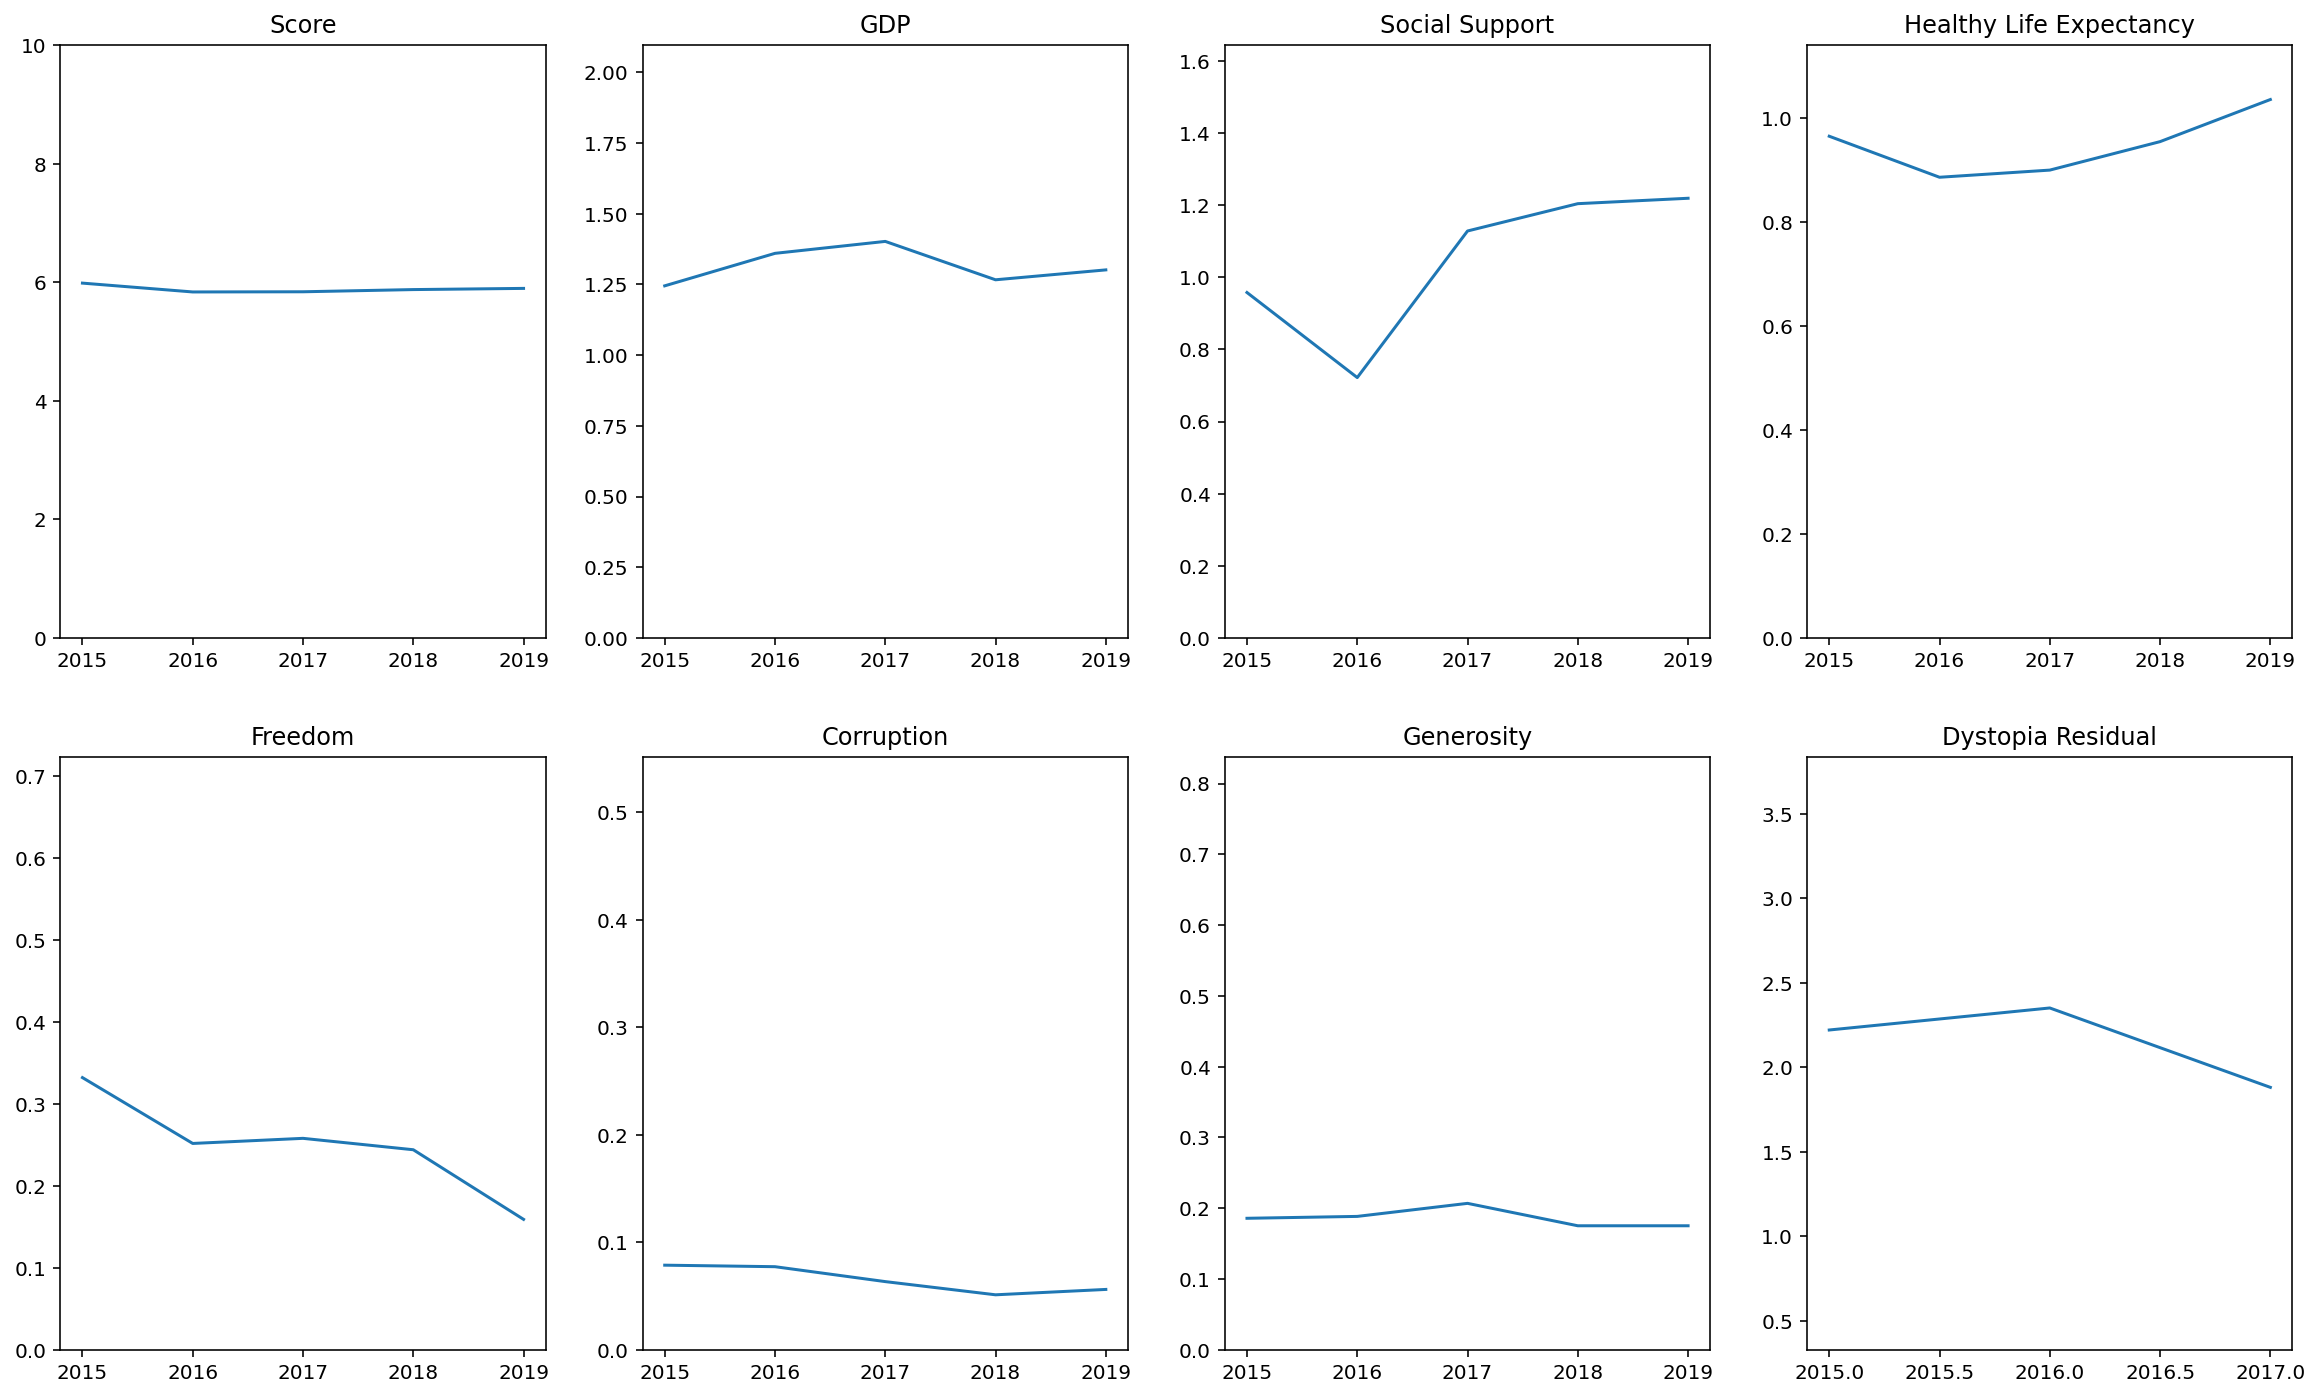

In [22]:
plt.figure(figsize=(20,12))
for iter, feature in enumerate(features_tmp):
    plt.subplot(2,4,iter+1)
    plt.plot(korea.Year, korea[feature])
    plt.title(feature)
    ymin = statistics[feature]['min']
    ymax = statistics[feature]['max']
    plt.ylim(ymin, ymax)
plt.show()

#대륙별 데이터 확인

##Democracy Index 상관관계 확인

In [77]:
democracy = pd.read_csv(join(WORKING_DIR, 'democracy_index.csv'))

In [78]:
democracy.head()

,Country,Overall Score,Rank,Electoral process and pluralism,Functioning of government,Political participation,Political culture,Civil liberties
0,Norway,9.87,1,10.00,9.64,10.00,10.00,9.71
1,Iceland,9.58,2,10.00,9.29,8.89,10.00,9.71
2,Sweden,9.39,3,9.58,9.64,8.33,10.00,9.41
3,New Zealand,9.26,4,10.00,9.29,8.89,8.13,10.00
4,Finland,9.25,5,10.00,8.93,8.89,8.75,9.71


In [79]:
hap_dem2019 = pd.merge(happiness2019, democracy[['Country', 'Overall Score']], on = 'Country', how = 'left')
hap_dem2019.rename(columns = {'Overall Score':'Democracy'},inplace=True)

In [80]:
country_null = hap_dem2019.Country[hap_dem2019.Democracy.isnull()==True].tolist()
dic_country_null = {i:None for i in country_null}
dic_country_null

{'United States': None,
 'Trinidad & Tobago': None,
 'Kosovo': None,
 'Northern Cyprus': None,
 'Bosnia and Herzegovina': None,
 'Kyrgyzstan': None,
 'Ivory Coast': None,
 'Congo (Brazzaville)': None,
 'Palestinian Territories': None,
 'Somalia': None,
 'Congo (Kinshasa)': None,
 'Swaziland': None,
 'South Sudan': None}

In [83]:
dic_country_null['United States'] = ['United States of America'] + democracy.index[democracy.Country == 'United States of America'].tolist()
dic_country_null['Trinidad & Tobago'] = ['Trinidad and Tobago'] + democracy.index[democracy.Country == 'Trinidad and Tobago'].tolist()
dic_country_null['Kosovo'] = None
dic_country_null['Northern Cyprus'] = None
dic_country_null['Bosnia and Herzegovina'] = ['Bosnia and Hercegovina'] + democracy.index[democracy.Country == 'Bosnia and Hercegovina'].tolist()
dic_country_null['Kyrgyzstan'] = ['Kyrgyz Republic'] + democracy.index[democracy.Country == 'Kyrgyz Republic'].tolist()
dic_country_null['Ivory Coast'] = None
dic_country_null['Congo (Brazzaville)'] = ['Congo(Brazzaville)'] + democracy.index[democracy.Country == 'Congo(Brazzaville)'].tolist()
dic_country_null['Palestinian Territories'] = ['Palestine'] + democracy.index[democracy.Country == 'Palestine'].tolist()
dic_country_null['Somalia'] = None
dic_country_null['Congo (Kinshasa)'] = None
dic_country_null['Swaziland'] = ['Switzerland'] + democracy.index[democracy.Country == 'Switzerland'].tolist()
dic_country_null['South Sudan'] = None

In [84]:
dic_country_null

{'United States': ['United States of America', 24],
 'Trinidad & Tobago': ['Trinidad and Tobago', 43],
 'Kosovo': None,
 'Northern Cyprus': None,
 'Bosnia and Herzegovina': ['Bosnia and Hercegovina', 101],
 'Kyrgyzstan': ['Kyrgyz Republic', 100],
 'Ivory Coast': None,
 'Congo (Brazzaville)': ['Congo(Brazzaville)', 133],
 'Palestinian Territories': ['Palestine', 116],
 'Somalia': None,
 'Congo (Kinshasa)': None,
 'Swaziland': ['Switzerland', 9],
 'South Sudan': None}

In [86]:
for country in dic_country_null.keys():
    if dic_country_null[country] == None:
        continue
    democracy.loc[dic_country_null[country][1], 'Country'] = dic_country_null[country][0]

In [92]:
hap_dem2019['Rank Group'] = hap_dem2019.Rank // 10 + 1

In [93]:
hap_dem2019.head()

,Rank,Country,Score,GDP,Social Support,Healthy Life Expectancy,Freedom,Generosity,Corruption,Democracy,Rank Group
0,1,Finland,7.769,1.340,1.587,0.986,0.596,0.153,0.393,9.25,1
1,2,Denmark,7.600,1.383,1.573,0.996,0.592,0.252,0.410,9.22,1
2,3,Norway,7.554,1.488,1.582,1.028,0.603,0.271,0.341,9.87,1
3,4,Iceland,7.494,1.380,1.624,1.026,0.591,0.354,0.118,9.58,1
4,5,Netherlands,7.488,1.396,1.522,0.999,0.557,0.322,0.298,9.01,1


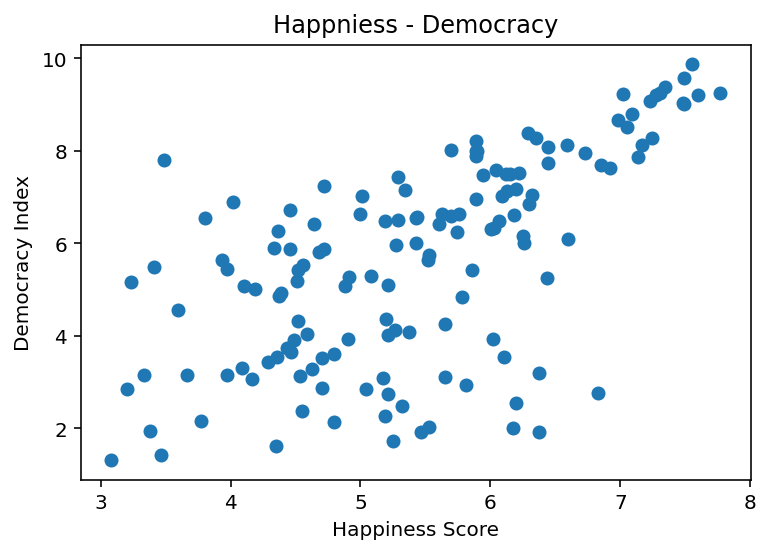

In [95]:
plt.scatter(hap_dem2019.Score, hap_dem2019.Democracy)
plt.title('Happniess - Democracy')
plt.xlabel('Happiness Score')
plt.ylabel('Democracy Index')
plt.show()

- Democracy Index가 높은데, Happiness Score가 낮은 경우
- Democracy Index가 낮은데, Happiness Score가 높은 경우